In [21]:
import os
import sys
import shap
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', 500)
sys.path.append('../src/')
from configs import *
from training import *
from plotting import *
from clustering import *
from tqdm.notebook import tqdm

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
rcParams.update(fig_params)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
feature_list = ['physicochemical',
                'AAC',
                'CKSAAP type 1',
                'TPC type 1',
                'DPC type 1',
                'DDE',
                'GAAC',
                'CKSAAGP type 1',
                'GDPC type 1',
                'GTPC type 1',
                'Moran',
                'Geary',
                'NMBroto',
                'CTDC',
                'CTDT',
                'CTDD',
                'CTriad',
                'KSCTriad',
                'SOCNumber',
                'QSOrder',
                'PAAC',
                'APAAC',
                'ASDC',
                'AC',
                'CC',
                'ACC',
                'EAAC',
                'EGAAC',
                'AAIndex',
                'BLOSUM62',
                'ZScale'
               ]

In [3]:
comb, features = load_dataset(feature_list=feature_list, dataset_name='comb', features_folder=os.path.join('..', 'features'))
train = comb[comb.Dataset=='train'].copy()
test  = comb[comb.Dataset=='test'].copy()

## Train LighCPP (20 features)

Training until validation scores don't improve for 20 rounds
[100]	cv_agg's train auc: 0.926267 + 0.00389047	cv_agg's valid auc: 0.909495 + 0.022844
[200]	cv_agg's train auc: 0.939826 + 0.00341086	cv_agg's valid auc: 0.91792 + 0.0246509
[300]	cv_agg's train auc: 0.948136 + 0.00372611	cv_agg's valid auc: 0.923423 + 0.0244926
[400]	cv_agg's train auc: 0.953556 + 0.00355105	cv_agg's valid auc: 0.927112 + 0.0245923
[500]	cv_agg's train auc: 0.956779 + 0.00341998	cv_agg's valid auc: 0.929405 + 0.0250501
Early stopping, best iteration is:
[547]	cv_agg's train auc: 0.957817 + 0.00340046	cv_agg's valid auc: 0.930524 + 0.0253806
[100]	training's auc: 0.924854	valid_1's auc: 0.910959
[200]	training's auc: 0.938117	valid_1's auc: 0.909096
[300]	training's auc: 0.947259	valid_1's auc: 0.909789
[400]	training's auc: 0.953099	valid_1's auc: 0.908642
[500]	training's auc: 0.956315	valid_1's auc: 0.908287
[600]	training's auc: 0.958599	valid_1's auc: 0.908334


,AUROC,MCC,F1,Fb05,Fb01,ACC,SN,SP
Train,0.957817,0.713693,0.808253,0.910752,0.990361,0.838570,0.680631,0.996509
Valid,0.930524,0.668815,0.776639,0.883498,0.968649,0.815019,0.647308,0.982547
Test_ensemble,0.908919,0.677275,0.698718,0.704134,0.707610,0.959846,0.689873,0.979386
Test_refit,0.908354,0.672905,0.694534,0.701299,0.705654,0.959419,0.683544,0.979386


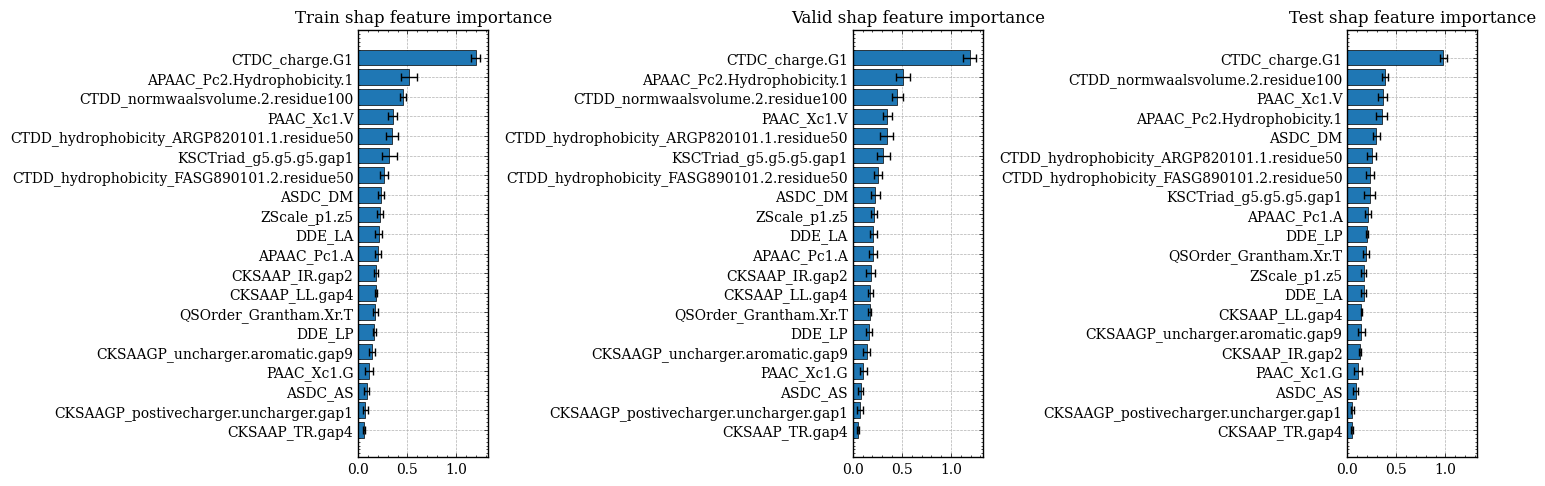

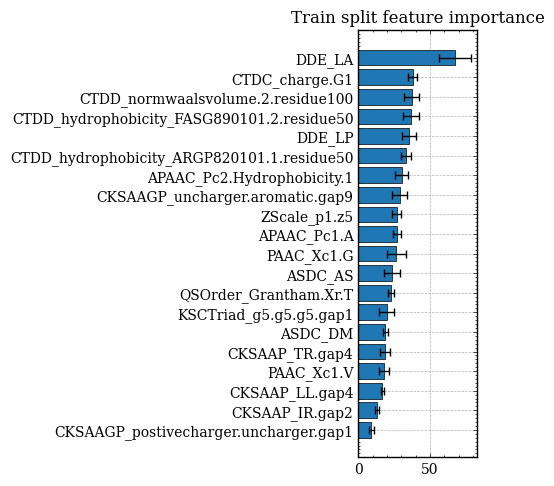

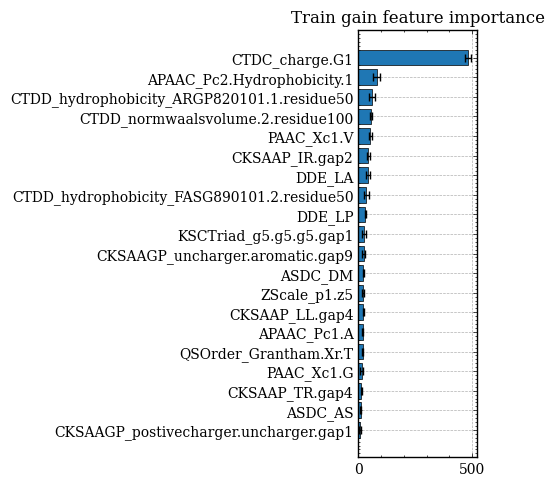

In [4]:
selected_features = ['CTDC_charge.G1',
                     'CTDD_hydrophobicity_ARGP820101.1.residue50',
                     'CKSAAP_IR.gap2',
                     'CTDD_normwaalsvolume.2.residue100',
                     'DDE_LA',
                     'ASDC_AS',
                     'PAAC_Xc1.V',
                     'APAAC_Pc2.Hydrophobicity.1',
                     'DDE_LP',
                     'CKSAAP_LL.gap4',
                     'APAAC_Pc1.A',
                     'CTDD_hydrophobicity_FASG890101.2.residue50',
                     'CKSAAGP_postivecharger.uncharger.gap1',
                     'KSCTriad_g5.g5.g5.gap1',
                     'ZScale_p1.z5',
                     'QSOrder_Grantham.Xr.T',
                     'ASDC_DM',
                     'CKSAAP_TR.gap4',
                     'PAAC_Xc1.G',
                     'CKSAAGP_uncharger.aromatic.gap9']

results = cross_validate(train=train,
                         test=test,
                         features=selected_features,
                         target=TARGET,
                         num_folds=NUM_FOLDS,
                         num_repeats=NUM_REPEATS,
                         seed=SEED,
                         params={**PARAMS_GB, **{'scale_pos_weight': 0.1, 'num_leaves': 2}},
                         threshold=0.5,
                         feval=None,
                         refit=True,
                         refit_multiplier=1.1,
                         train_score=True,
                         train_importances=True,
                         valid_importances=True,
                         test_importances=True,
                         importance_type_list=['split', 'gain', 'shap'])
print_results(results)
plot_importance(results, selected_features, max_features=20)

## Model intepretation

### Cluster dependent features

In [9]:
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    os.environ["PYTHONWARNINGS"] = 'ignore'

corr_matrix = compute_redundancy(train[selected_features], method='model_based', n_jobs=50, verbose=10)

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.
[Parallel(n_jobs=50)]: Done  13 tasks      | elapsed:    3.4s
[Parallel(n_jobs=50)]: Done  28 tasks      | elapsed:    3.6s
[Parallel(n_jobs=50)]: Done  45 tasks      | elapsed:    3.7s
[Parallel(n_jobs=50)]: Done  62 tasks      | elapsed:    3.9s
[Parallel(n_jobs=50)]: Done  81 tasks      | elapsed:    4.0s
[Parallel(n_jobs=50)]: Done 111 out of 190 | elapsed:    4.2s remaining:    3.0s
[Parallel(n_jobs=50)]: Done 131 out of 190 | elapsed:    4.4s remaining:    2.0s
[Parallel(n_jobs=50)]: Done 151 out of 190 | elapsed:    4.5s remaining:    1.2s
[Parallel(n_jobs=50)]: Done 171 out of 190 | elapsed:    4.6s remaining:    0.5s
[Parallel(n_jobs=50)]: Done 190 out of 190 | elapsed:    5.5s finished


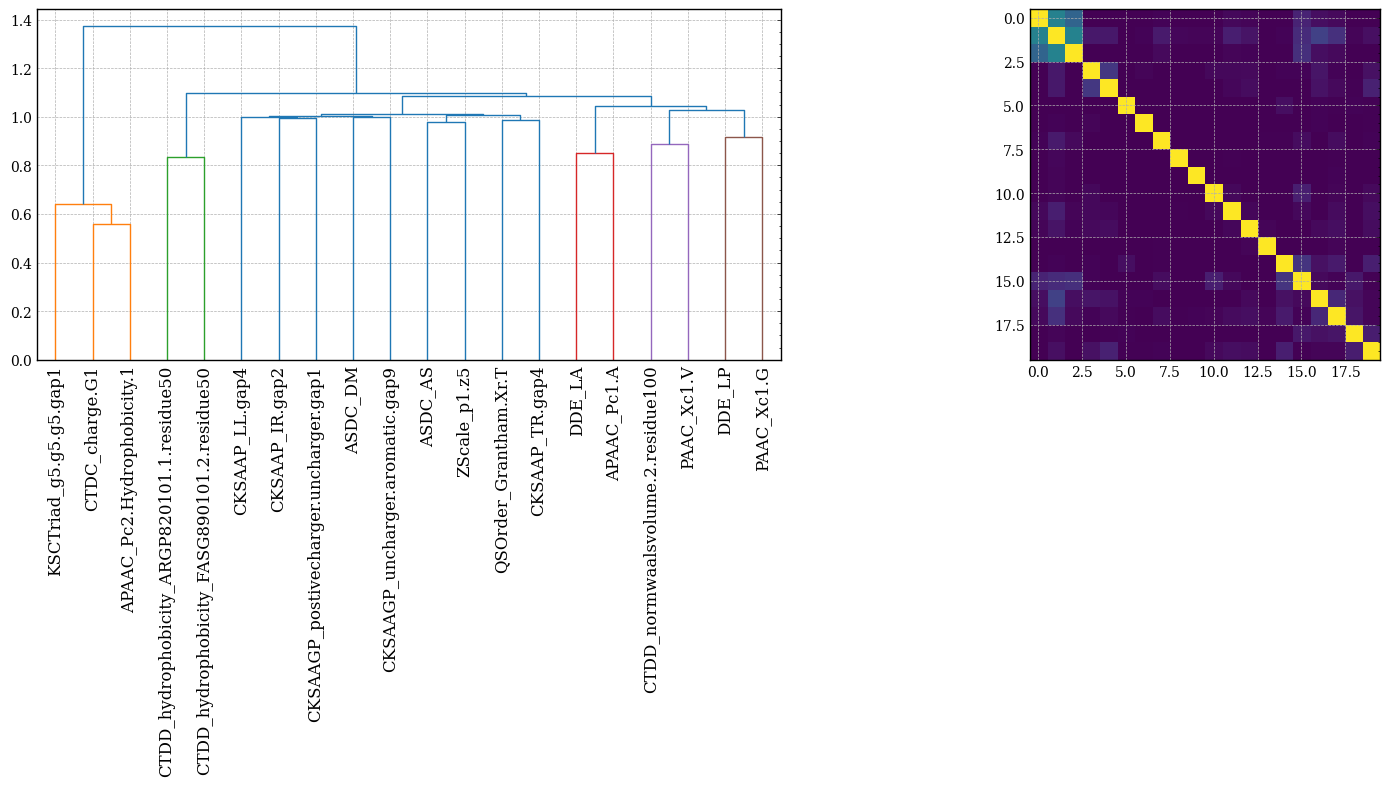

In [10]:
dist_linkage = features_clustering(corr_matrix, show=True)

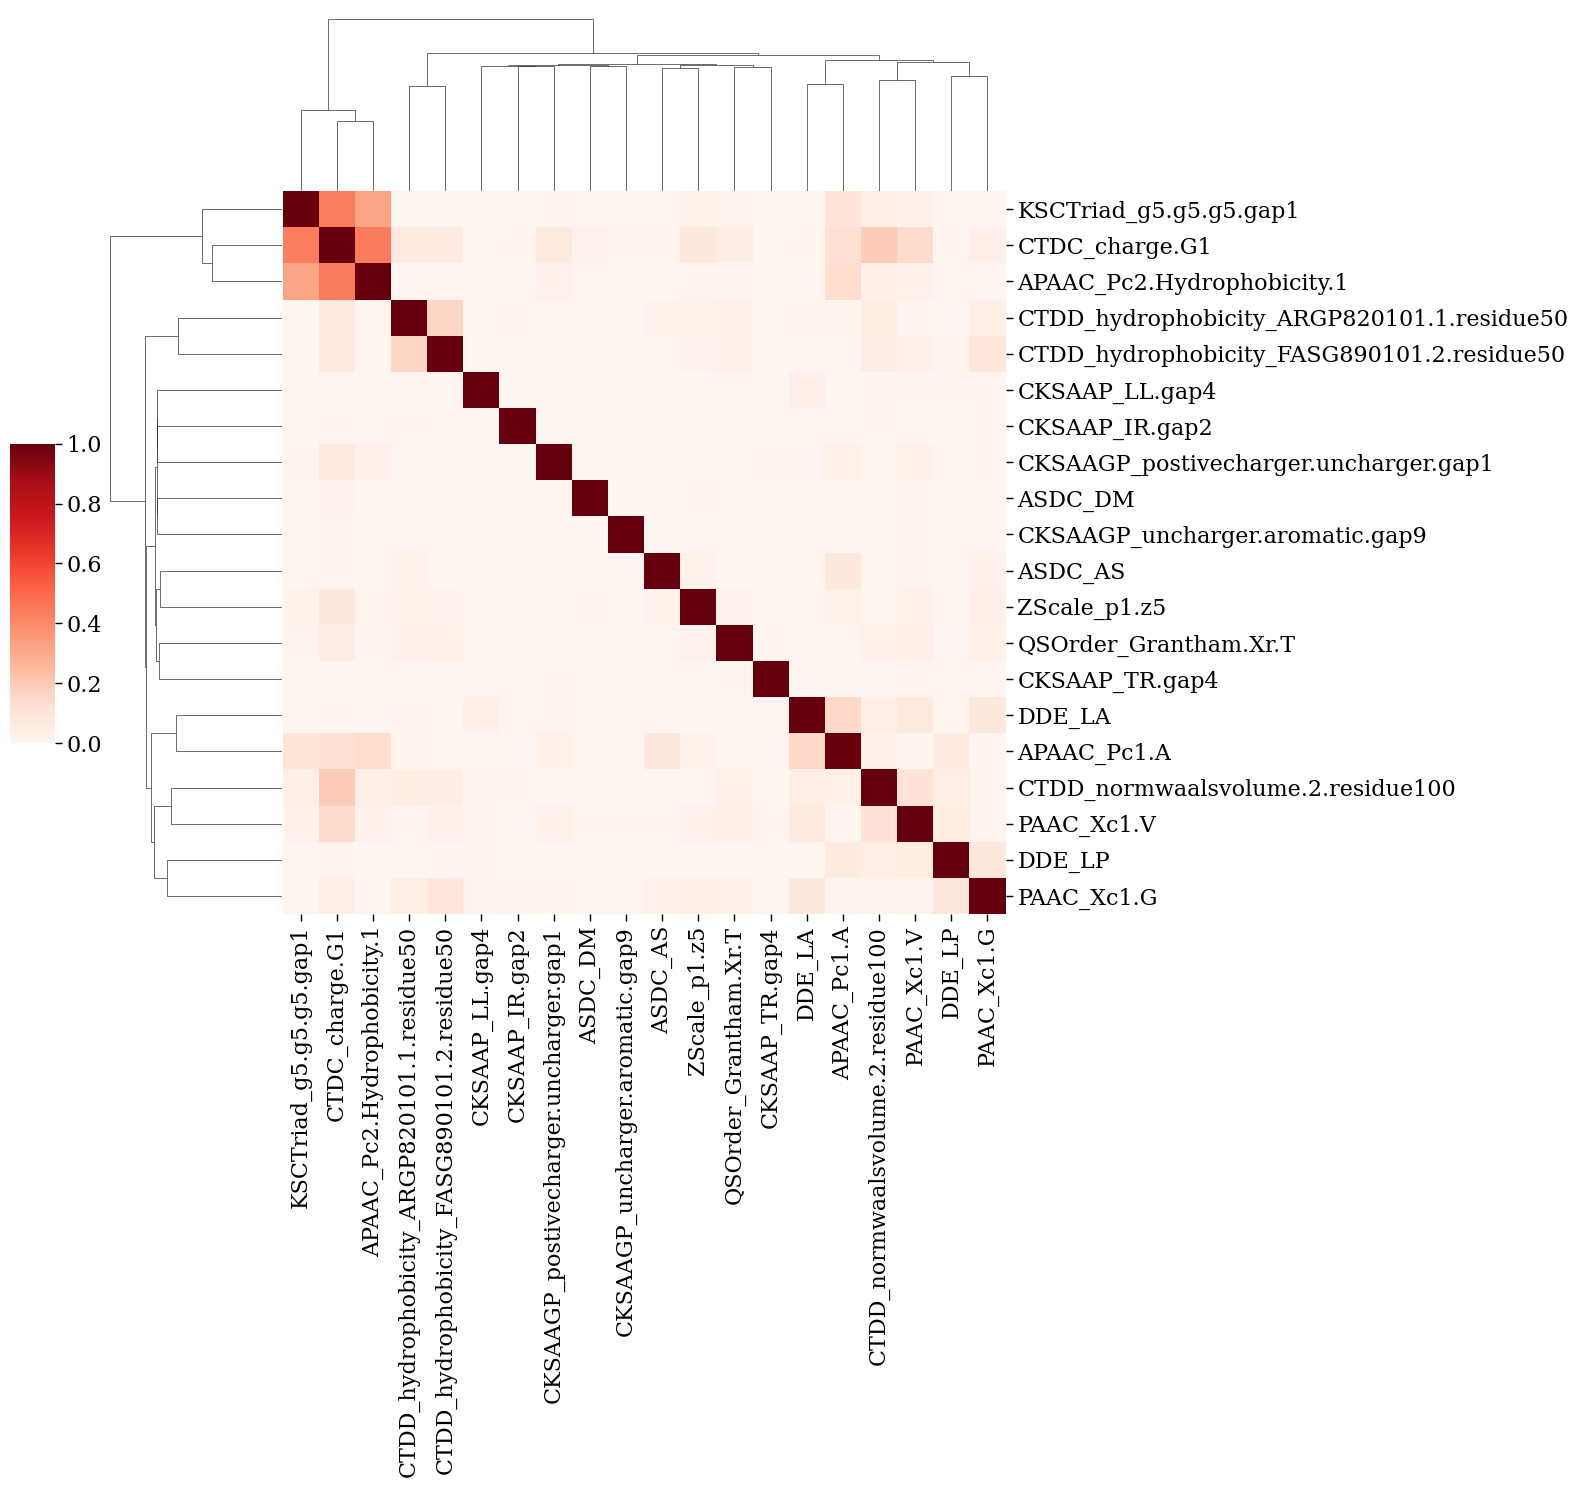

In [41]:
fig_params['figure.figsize'] = (15,15)
fig_params['xtick.minor.visible'] = False
fig_params['ytick.minor.visible'] = False
fig_params['xtick.top'] = False
fig_params['ytick.right'] = False
fig_params['xtick.direction'] = 'out'
fig_params['ytick.direction'] = 'out'
fig_params['xtick.labelsize'] = 16
fig_params['ytick.labelsize'] = 16
fig_params['axes.labelsize'] = 16
fig_params['xtick.major.size'] = 5
fig_params['ytick.major.size'] = 5
fig_params['xtick.major.width'] = 1
fig_params['ytick.major.width'] = 1
fig_params['axes.grid'] = False
rcParams.update(fig_params)

fig = sns.clustermap(corr_matrix,
                     method='ward',
                   metric='euclidean',
                   figsize=(15, 15),
                   row_linkage=dist_linkage, 
                   col_linkage=dist_linkage,
                   #dendrogram_ratio=(.1, .1),
                   cbar_pos=(-0.05, 0.5, .03, .2),
                   cbar_kws={'shrink': .80},# 'label': 'Dependence'},
                   cmap='Reds')

In [42]:
FIG_SIZE = (15,15)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'Features_clustering',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)

### Compute Shapley values

Warning: The following computation is intensive.

In [36]:
masker = shap.maskers.Partition(train[selected_features], clustering=dist_linkage)
explainer = shap.PartitionExplainer(results['models']['refit_model'].predict, masker)
shap_values_train = explainer(train[selected_features])
shap_values_test = explainer(test[selected_features])

Partition explainer: 1147it [27:16,  1.44s/it]                                  
Partition explainer: 2342it [51:40,  1.33s/it]                                  


In [37]:
import pickle

## Save shap values
d = {'shap_values_train': shap_values_train, 'shap_values_test': shap_values_test}
with open(os.path.join('..', 'results', 'shap_values.pickle'), 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Global interpretation: feature importance

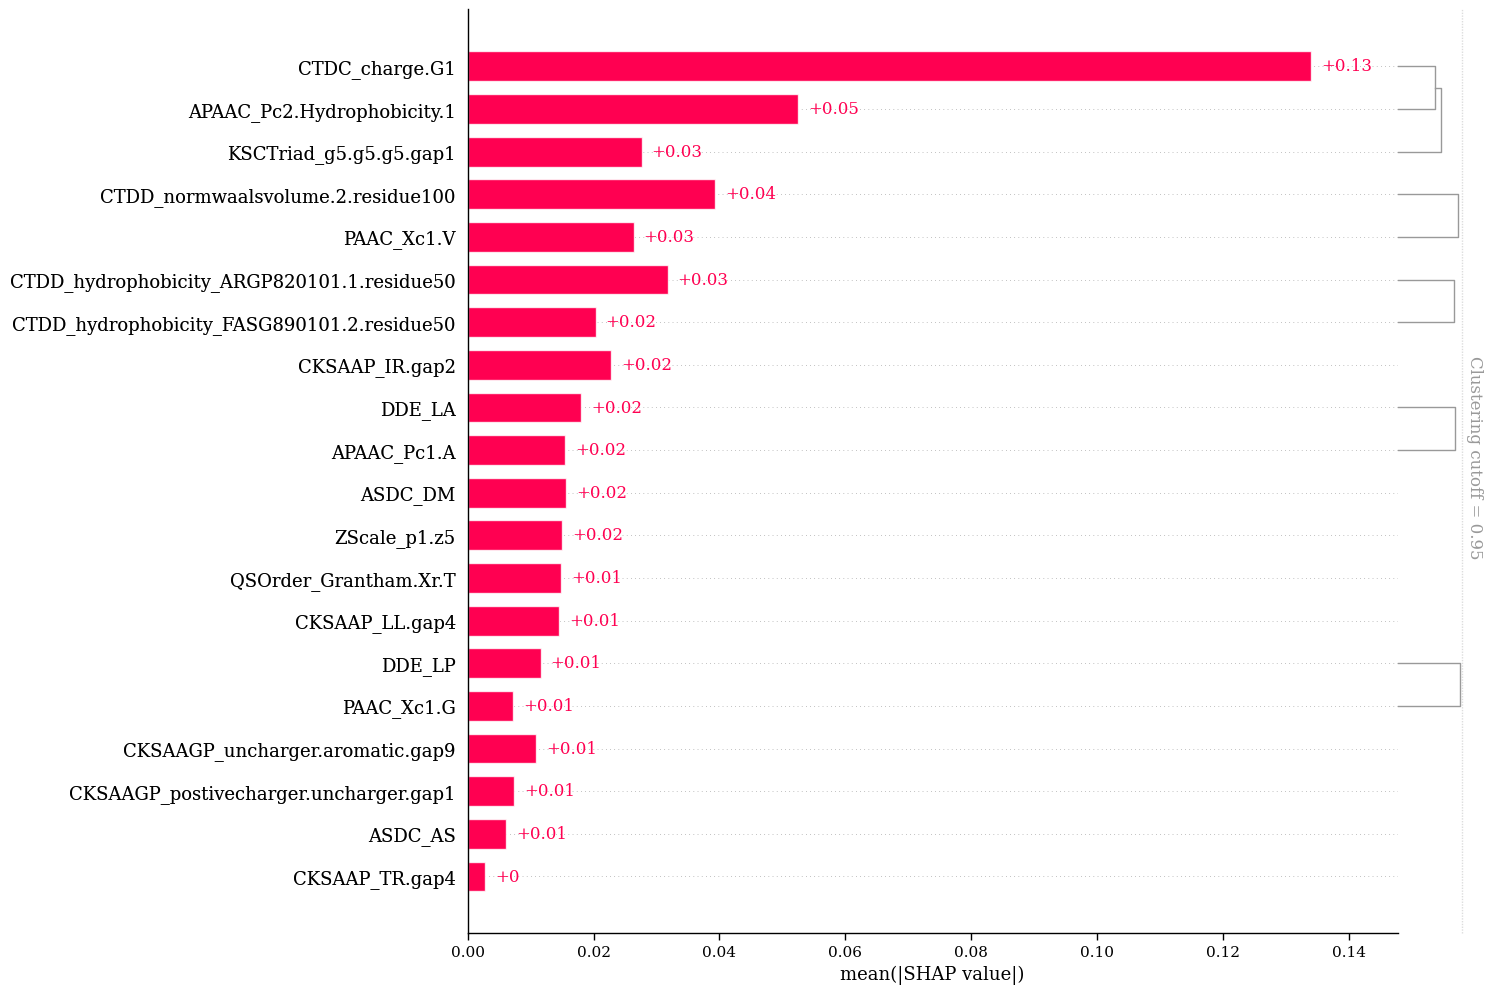

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
shap.plots.bar(shap_values_train, max_display=20, show=False, clustering_cutoff=0.95)

FIG_SIZE = (12,12)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'Feature_importance_training',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)

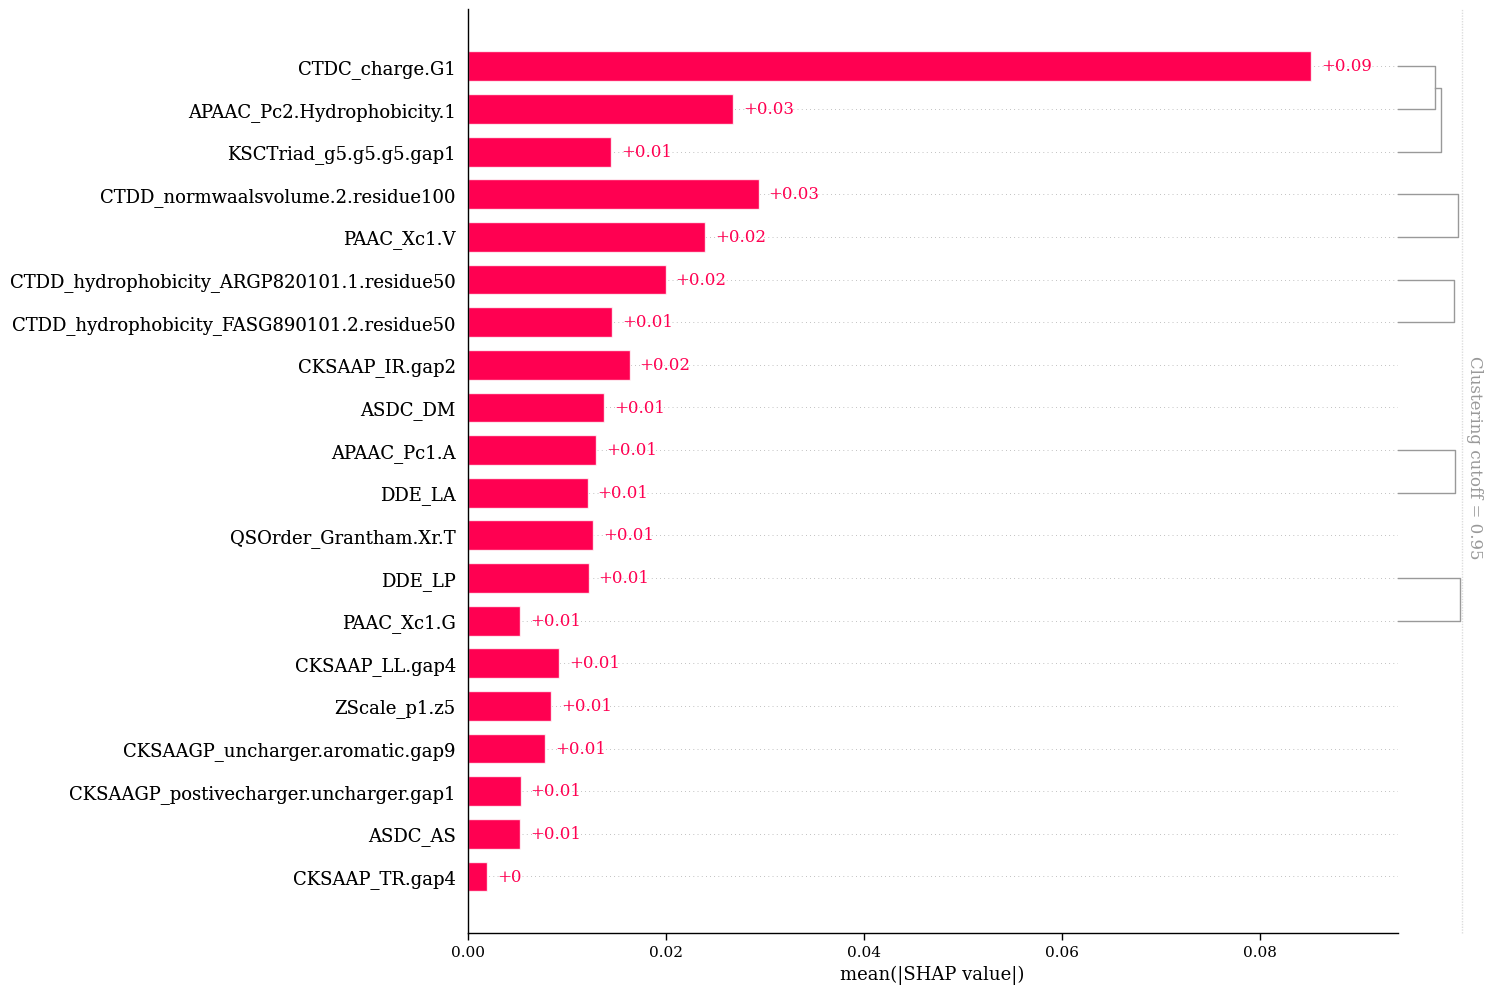

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
shap.plots.bar(shap_values_test, max_display=20, show=False, clustering_cutoff=0.95)

FIG_SIZE = (12,12)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'Feature_importance_test',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)

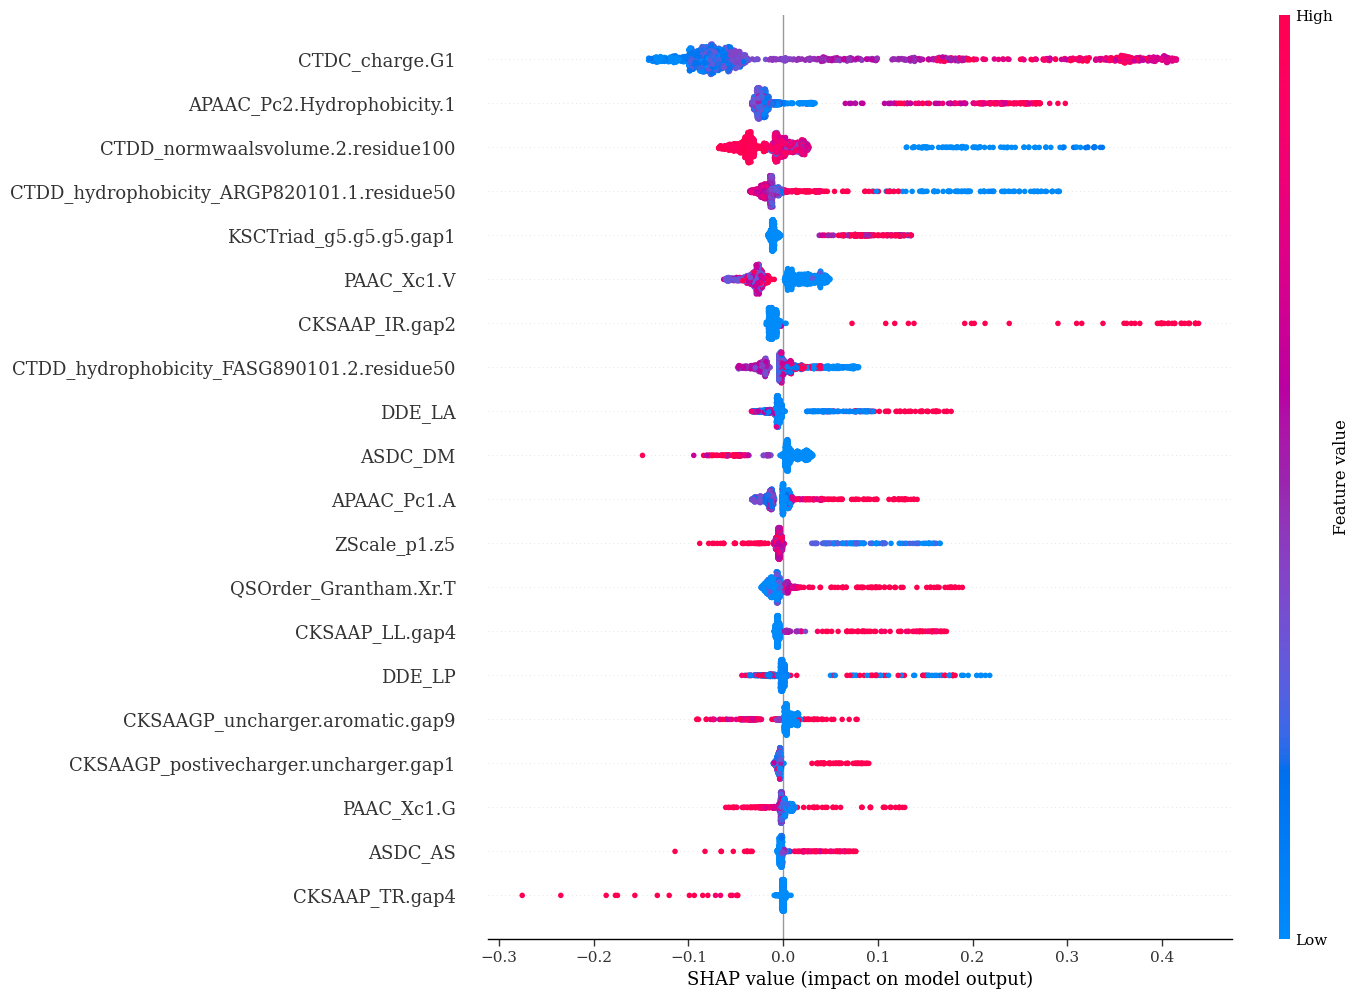

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
shap.plots.beeswarm(shap_values_train, max_display=20, show=False)

FIG_SIZE = (12,12)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'shap_training',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)

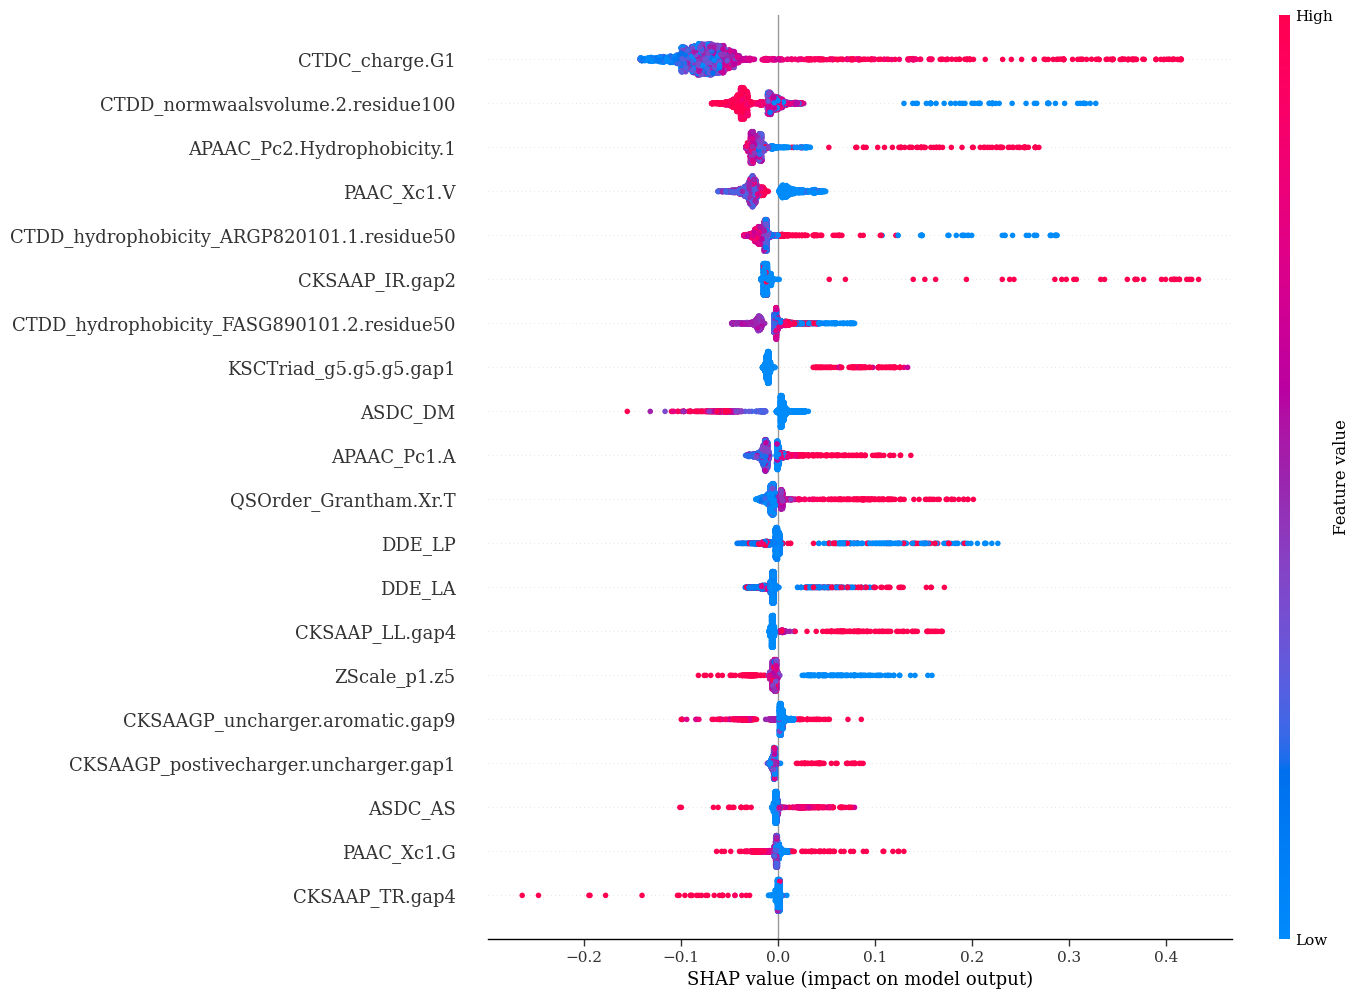

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
shap.plots.beeswarm(shap_values_test, max_display=20, show=False)

FIG_SIZE = (12,12)
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

save_fig(
    fig,
    'shap_test',
    fig_dir=os.path.join('..','figures'),
    fig_fmt=FIG_FMT,
    save=SAVE_FIG, 
    fig_size=FIG_SIZE,
    transparent_png=TRANSPARENT_PNG,
)